★実行環境の選択

In [201]:
# VSCodeの場合
# edi_flg = 1
# Googlre Colabの場合
edi_flg = 0

In [202]:
if edi_flg == 0:
  # GoogleColabにGitHubリポジトリをクローンする用
  %cd /content/My_Python_project

  from google.colab import auth
  auth.authenticate_user()
  !git clone https://github.com/keiseki-eng/My_Python_project
  !git pull origin main



/content/My_Python_project
fatal: destination path 'My_Python_project' already exists and is not an empty directory.
From https://github.com/keiseki-eng/My_Python_project
 * branch            main       -> FETCH_HEAD
Already up to date.


In [203]:
# import sys
# !{sys.executable} -m pip install ipykernel

In [204]:
if edi_flg == 0:
    !pip install japanize-matplotlib

import os
import sys
import yaml
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import japanize_matplotlib #日本語表示対応
from sklearn.model_selection import KFold


# Notebook から src ディレクトリを追加
# sys.path.append(os.path.join(os.getcwd(), "src"))
sys.path.append("/home/keiseki/My_Python_project/src")

# これで src/preprocess/make_tag_features.py が import 可能
# from preprocess.make_tag_features import create_tag_features, extract_unique_tags

In [205]:
if edi_flg == 0:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [206]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=pd.errors.PerformanceWarning
)

## 01.config読み込み

In [207]:
# VSCode用
if edi_flg==1:
  conf_path = os.path.join( '../config/config.yaml')
  with open(conf_path, 'r') as f:
    config = yaml.safe_load(f)

# GoogleColab用
elif edi_flg==0:
  conf_path = "My_Python_project/config/config.yaml"
  with open(conf_path, "r") as f:
    config = yaml.safe_load(f)

In [208]:
# 定義した特徴量リストを読み込み
feature_list = config['FEATURE']['FEATURE_LIST']

In [209]:
# カテゴリカルカラムのリストを定義
categorical_cols = config['FEATURE']['CATEGORICAL_COLS']

## 02.データ読み込み

In [210]:
# VSCode用
if edi_flg==1:
# ドライブ内のファイルパスを指定
    train_path = '../20.Data/processed_train.pkl'
    df_train = pd.read_pickle(train_path)

# GoogleColab用
elif edi_flg==0:
    # GoogleDriveをマウントしてファイル読み込み準備
    from google.colab import drive
    drive.mount('/content/drive')
    # ドライブ内のファイルパスを指定
    train_path = '/content/drive/MyDrive/Colab Notebooks/不動産予測/processed_train.pkl'
    df_train = pd.read_pickle(train_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [211]:
# testデータの読み込み
# VSCode用
if edi_flg==1:
    test_path = '../20.Data/processed_test.pkl'
    df_test = pd.read_pickle(test_path)

# GoogleColab用
elif edi_flg==0:
    # ドライブ内のファイルパスを指定
    test_path = '/content/drive/MyDrive/Colab Notebooks/不動産予測/processed_test.pkl'
    df_test = pd.read_pickle(test_path)

## ★うまく行けば特徴量作成ファイル、configに反映！価格帯のような特徴量を作成

In [212]:
MAX_LOG = 15  # expm1(15) ≒ 3,269,000

def safe_expm1(x):
    return np.expm1(np.clip(x, -10, MAX_LOG))


In [213]:
# ===============================
# 擬似 price_band 作成（リークなし）
# ===============================

def make_pseudo_price(df):
    score = (
        # 面積（最重要）
        0.55 * np.log1p(df["unit_area"])

        # 駅距離（近いほど高い）
        - 0.30 * np.log1p(df["walk_distance1"] + 1)

        # 築年数（新しいほど高い）
        - 0.20 * np.log1p(df["building_age"] + 1)

        # 間取り数（部屋数が多いほど高い）
        + 0.15 * np.log1p(df["room_count"] + 1)
    )

    # walk_distance2 が存在すれば軽く効かせる
    if "walk_distance2" in df.columns:
        score -= 0.10 * np.log1p(df["walk_distance2"] + 1)

    return score



In [214]:
# 擬似 price スコア
df_train["pseudo_price"] = make_pseudo_price(df_train)
df_test["pseudo_price"] = make_pseudo_price(df_test)

# train の分位点で price_band を作る（重要）
bins = pd.qcut(df_train["pseudo_price"], q=5, retbins=True)[1]

df_train["pseudo_price_band"] = pd.cut(
    df_train["pseudo_price"], bins=bins, labels=False, include_lowest=True
)

df_test["pseudo_price_band"] = pd.cut(
    df_test["pseudo_price"], bins=bins, labels=False, include_lowest=True
)

## addr1+2に対し、ターゲットエンコーディングを実装

In [215]:
from sklearn.model_selection import KFold
import numpy as np

def target_encode_oof(
    df,
    col,
    target,
    n_splits=5,
    smoothing=10,
    random_state=42
):
    df = df.copy()

    # ★ここが最重要
    df[target] = df[target].astype(float)
    global_mean = df[target].mean()

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    te_col = np.zeros(len(df))

    for train_idx, valid_idx in kf.split(df):
        train_fold = df.iloc[train_idx]
        valid_fold = df.iloc[valid_idx]

        stats = (
            train_fold
            .groupby(col, observed=True)[target]
            .agg(["mean", "count"])
        )

        stats["smooth"] = (
            stats["count"] * stats["mean"]
            + smoothing * global_mean
        ) / (stats["count"] + smoothing)

        te_col[valid_idx] = (
            valid_fold[col]
            .map(stats["smooth"])
            .astype(float)          # ← ★ここでカテゴリ解除
            .fillna(global_mean)
            .values
          )


    df[f"{col}_TE"] = te_col
    return df, global_mean


In [216]:
df_train, addr1_2_global_mean = target_encode_oof(
    df_train,
    col="addr1+2",
    target="money_room",
    n_splits=5,
    smoothing=20
)


In [217]:
stats_full = df_train.groupby("addr1+2")["money_room"].agg(["mean", "count"])

stats_full["smooth"] = (
    stats_full["count"] * stats_full["mean"]
    + 20 * addr1_2_global_mean
) / (stats_full["count"] + 20)

# df_test["addr1+2_TE"] = df_test["addr1+2"].map(stats_full["smooth"])
# df_test["addr1+2_TE"].fillna(addr1_2_global_mean, inplace=True)
df_test["addr1+2_TE"] = (
    df_test["addr1+2"]
    .map(stats_full["smooth"])
    .astype(float)                 # ← ★最重要
    .fillna(addr1_2_global_mean)   # ← inplace を使わない
)



/tmp/ipython-input-431935882.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats_full = df_train.groupby("addr1+2")["money_room"].agg(["mean", "count"])


In [218]:
# 実際の売買価格で定義し直す
def make_price_band_by_quantile(price, n_bins=5):
    return pd.qcut(price, q=n_bins, labels=False)

df_train["price_band"] = make_price_band_by_quantile(
    df_train["money_room"],
    n_bins=5
)

def make_sample_weight(price_band):
    weight_map = {
        0: 9.0,   # 最低価格帯
        1: 2.0,
        2: 1.2,
        3: 1.2,
        4: 1.0    # 高価格帯
    }
    return price_band.map(weight_map).astype(float)
df_train["sample_weight"] = make_sample_weight(
    df_train["price_band"]
)

## interaction特徴量を追加

In [219]:
df_train["unit_area_x_building_age"] = df_train["unit_area"] * df_train["building_age"]
df_train["unit_area_x_addr_te"]    = df_train["unit_area"] * df_train["addr1+2_TE"]
df_test["unit_area_x_building_age"] = df_test["unit_area"] * df_test["building_age"]
df_test["unit_area_x_addr_te"]    = df_train["unit_area"] * df_test["addr1+2_TE"]

In [220]:
feature_list = feature_list + ["pseudo_price_band"]
feature_list = feature_list + ["addr1+2_TE"]
feature_list = feature_list + ["unit_area_x_building_age"]
feature_list = feature_list + ["unit_area_x_addr_te"]
categorical_cols = categorical_cols + ["pseudo_price_band"]


## 05.train/valid 分割　＆　target加工

＿★サンプルウェイトを価格帯別に調整可能とする

In [221]:
# X_all, X_train, X_validの再構築
X_all = df_train[feature_list]
y_all = df_train["money_room"]

# log変換前の元価格を保存（後段の重み付け用）
y_price_raw = df_train.loc[X_all.index, "money_room"]

# unit_areaも対数変換
X_all["unit_area"] = np.log1p(X_all["unit_area"])


# unit_areaを２分割
X_all_low = X_all[X_all["unit_area"] < 4.5]
X_all_high = X_all[X_all["unit_area"] >= 4.5]
df_train["unit_area"] = np.log1p(df_train["unit_area"])
df_train_low = df_train[df_train["unit_area"] < 4.5]
df_train_high = df_train[df_train["unit_area"] >= 4.5]



# 目的変数が右に裾野が広いので対数変換
y_all = np.log1p(y_all)
y_all_low = y_all[X_all_low.index]
y_all_high = y_all[X_all_high.index]

X_train_low, X_valid_low, y_train_low, y_valid_low, w_train_low, w_valid_low = train_test_split(X_all_low, y_all_low, df_train_low["sample_weight"], test_size=0.2, random_state=42)
X_train_high, X_valid_high, y_train_high, y_valid_high, w_train_high, w_valid_high = train_test_split(X_all_high, y_all_high, df_train_high["sample_weight"], test_size=0.2, random_state=42)


/tmp/ipython-input-543578805.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_all["unit_area"] = np.log1p(X_all["unit_area"])


## 06.sample_weight適用

## 07.モデル学習

In [222]:
# カスタム評価関数（eval_metric形式）
def mape_eval(preds, train_data):
    y_true = np.expm1(train_data.get_label())
    y_pred = np.expm1(preds)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-7))) * 100
    return 'mape', mape, False


In [223]:
# LightGBM のパラメータ設定
params = config['MODEL_PARAMS']

# LightGBM のデータセットを作成
lgb_train_low = lgb.Dataset(
    X_train_low,
    y_train_low,
    # weight=sample_weight.loc[X_train.index],
    weight=w_train_low,
    categorical_feature=categorical_cols
)
lgb_train_high = lgb.Dataset(
    X_train_high,
    y_train_high,
    # weight=sample_weight.loc[X_train.index],
    weight=w_train_high,
    categorical_feature=categorical_cols
)

lgb_test_low = lgb.Dataset(
    X_valid_low,
    y_valid_low,
    reference=lgb_train_low,
    categorical_feature=categorical_cols
)
lgb_test_high = lgb.Dataset(
    X_valid_high,
    y_valid_high,
    reference=lgb_train_high,
    categorical_feature=categorical_cols
)


In [224]:
# モデルの学習
model_low = lgb.train(params,
                  lgb_train_low,
                  valid_sets=[lgb_train_low, lgb_test_low],
                  feval=mape_eval,  # ← カスタム評価関数を指定
                  callbacks=[lgb.early_stopping(stopping_rounds=1000, verbose=False)
                  ]) #early_stoppingあり
model_high = lgb.train(params,
                  lgb_train_high,
                  valid_sets=[lgb_train_high, lgb_test_high],
                  feval=mape_eval,  # ← カスタム評価関数を指定
                  callbacks=[lgb.early_stopping(stopping_rounds=1000, verbose=False)
                  ]) #early_stoppingあり


## 08.評価

特徴量の重要度


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

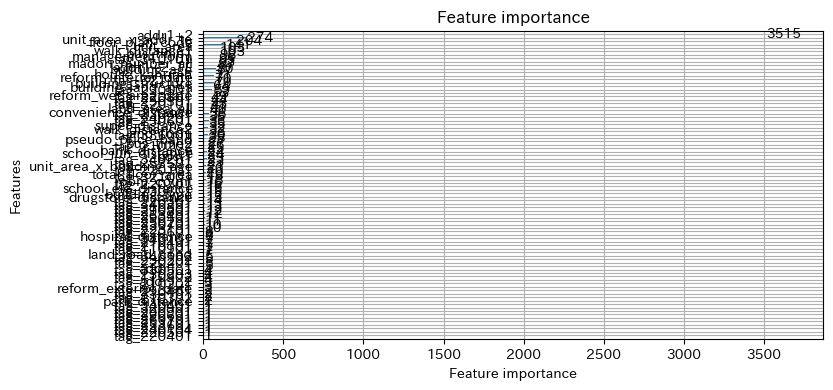

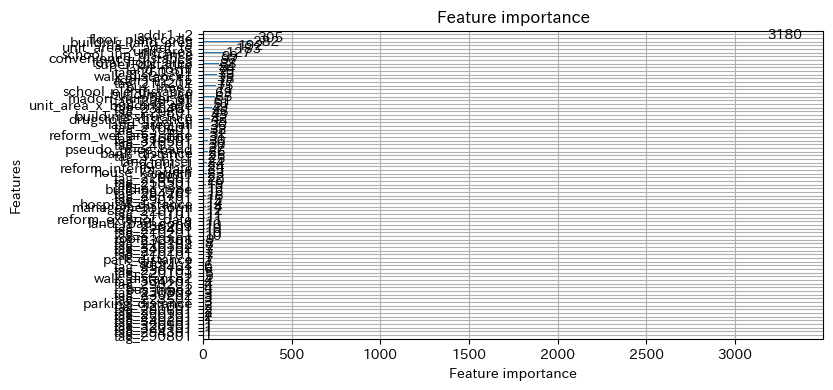

In [225]:
# テストデータで予測
y_pred_low = model_low.predict(X_valid_low , num_iteration=model_low.best_iteration)
y_pred_high = model_high.predict(X_valid_high , num_iteration=model_high.best_iteration)

# 対数変換を戻す
y_pred_low = np.expm1(y_pred_low)
y_valid_low = np.expm1(y_valid_low)
y_pred_high = np.expm1(y_pred_high)
y_valid_high = np.expm1(y_valid_high)

# yp = pd.DataFrame(y_pred,columns=["%"]) # ???????????????????????????//


# 特徴量の重要度
print("特徴量の重要度")
lgb.plot_importance(model_low, figsize=(8,4))
lgb.plot_importance(model_high, figsize=(8,4))


## 09.可視化（importance SHAP）

In [226]:

# import lightgbm as lgb
# from sklearn.model_selection import GridSearchCV

# # パラメータの探索範囲を指定
# param_grid = {
#     'num_leaves': [20, 30, 40],
#     'learning_rate': [0.01, 0.1, 0.5],
#     'max_depth': [5, 10]
# }




# # グリッドサーチCV
# gsearch = GridSearchCV(gbm, param_grid, cv=5) #cvは交差検証の回数

# # データを学習
# gsearch.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)])



# # 最適なパラメータとスコアを表示
# print('Best parameters found by grid search are:', gsearch.best_params_)
# print('Best score:', gsearch.best_score_)


In [227]:
# # パラメータの辞書を結合
# best_params = {**params, **gsearch.best_params_}

# # 最適パラメータでモデルを再学習
# model = lgb.LGBMClassifier(**best_params)
# model.fit(X_train, y_train)

In [228]:
#SHAP値の取得
explainer_low = shap.TreeExplainer(model=model_low)#SHAP値を取得するためのモデル作成
shap_values_low = explainer_low.shap_values(X=X_valid_low)#説明変数それぞれの値のSHAP値を取得する
explainer_high = shap.TreeExplainer(model=model_high)#SHAP値を取得するためのモデル作成
shap_values_high = explainer_high.shap_values(X=X_valid_high)#説明変数それぞれの値のSHAP値を取得する

# print(shap_values)
# print(shap_values.shape)


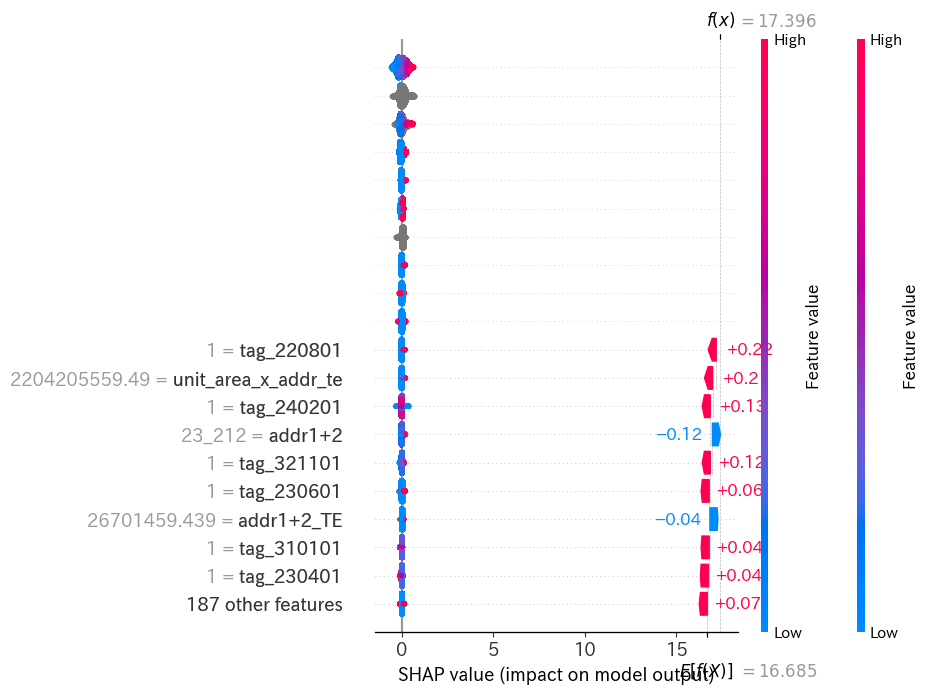

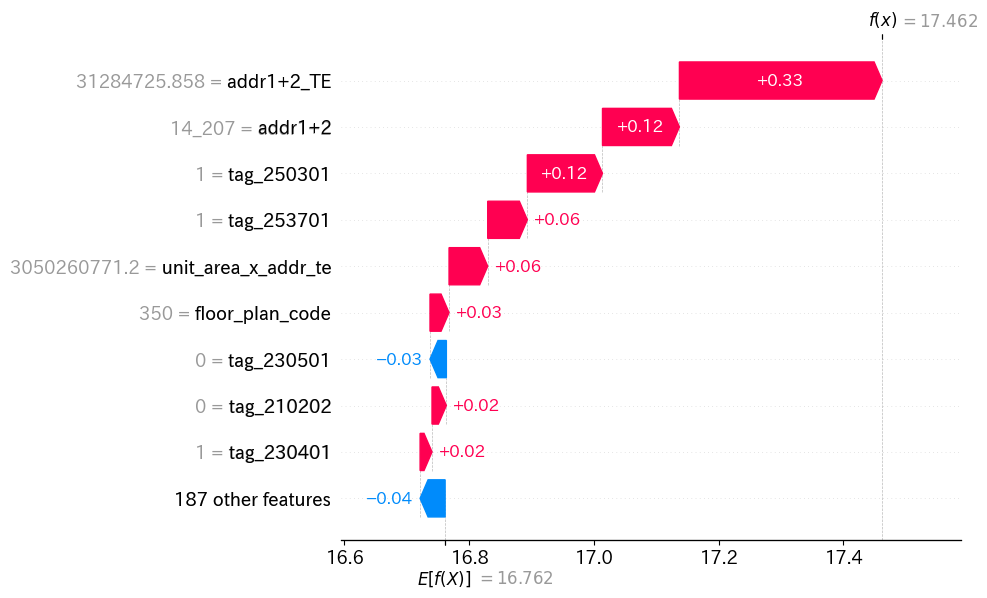

In [229]:

# 変数別の影響度の可視化
shap.initjs()
# shap.summary_plot(shap_values_low, X_valid_low, plot_type="bar", show=False)
shap.summary_plot(shap_values_low, X_valid_low, show=False)
shap.summary_plot(shap_values_high, X_valid_high, show=False)

# 0番目のデータポイントを再選択
i = 0
single_observation_low = X_valid_low.iloc[i:i+1,:]
single_observation_high = X_valid_high.iloc[i:i+1,:]

#print(single_observation)


# Explainerを使って説明を再計算
single_shap_values_low = explainer_low(single_observation_low)
single_shap_values_high = explainer_high(single_observation_high)

# waterfallプロットの生成
shap.waterfall_plot(single_shap_values_low[0])
shap.waterfall_plot(single_shap_values_high[0])

## 10.推論、提出

## 提出用データの作成

In [230]:
# 特徴量の選定
# df_test_p = df_test[feature_list].copy()
# df_test_p["unit_area"] = np.log1p(df_test_p["unit_area"])

# df_test_p_low = df_test_p[df_test_p["unit_area"] < 4.5]
# df_test_p_high = df_test_p[df_test_p["unit_area"] >= 4.5]




# # 提出データに対する予測（確率値）
# y_scores_submit_low = model_low.predict(df_test_p_low)
# y_scores_submit_low= np.expm1(y_scores_submit_low)
# y_scores_submit_high = model_high.predict(df_test_p_high)
# y_scores_submit_high= np.expm1(y_scores_submit_high)

# 元の index を保持
df_test_p = df_test[feature_list].copy()
df_test_p["unit_area"] = np.log1p(df_test_p["unit_area"])

# 分割（indexは保持される）
df_test_p_low  = df_test_p[df_test_p["unit_area"] < 4.5]
df_test_p_high = df_test_p[df_test_p["unit_area"] >= 4.5]

# 予測
y_pred_low  = np.expm1(model_low.predict(df_test_p_low))
y_pred_high = np.expm1(model_high.predict(df_test_p_high))

# ★ index 付き Series にする
pred_low  = pd.Series(y_pred_low,  index=df_test_p_low.index)
pred_high = pd.Series(y_pred_high, index=df_test_p_high.index)

# ★ 空の Series を作って元の index で埋める
y_submit = pd.Series(index=df_test_p.index, dtype=float)
y_submit.loc[pred_low.index]  = pred_low
y_submit.loc[pred_high.index] = pred_high

# idxを除いた数値を抽出
y_scores_submit = y_submit.values
# y_scores_submit.max()
y_scores_submit = np.clip(y_scores_submit, 6e6, 1e8)

y_scores_submit.max()


# print(y_scores_submit)
# print(y_scores_submit_low)
# print(y_scores_submit_high)


np.float64(100000000.0)

In [231]:
# モデル別のMAPEを確認


y_pred_valid_low  = np.expm1(model_low.predict(X_valid_low))
y_pred_valid_high = np.expm1(model_high.predict(X_valid_high))

# y_true_valid_low  = np.expm1(y_valid_low)
# y_true_valid_high = np.expm1(y_valid_high)

y_true_valid_low  = y_valid_low
y_true_valid_high = y_valid_high










def safe_mape(y_true, y_pred):
    mask = (y_true > 0) & np.isfinite(y_pred)
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))

pred_low  = pd.Series(y_pred_valid_low,  index=X_valid_low.index)
pred_high = pd.Series(y_pred_valid_high, index=X_valid_high.index)

true_low  = pd.Series(y_true_valid_low,  index=X_valid_low.index)
true_high = pd.Series(y_true_valid_high, index=X_valid_high.index)

y_pred_valid_all = pd.concat([pred_low, pred_high]).sort_index()
y_true_valid_all = pd.concat([true_low, true_high]).sort_index()

low_mape = (y_true_valid_low - y_pred_valid_low).abs().mean() / y_true_valid_low.mean()
high_mape = (y_true_valid_high - y_pred_valid_high).abs().mean() / y_true_valid_high.mean()
mape_valid = safe_mape(y_true_valid_all, y_pred_valid_all)
print(f"valid MAPE: {mape_valid * 100:.2f}%")
print(f"low MAPE: {low_mape * 100:.2f}%")
print(f"high MAPE: {high_mape * 100:.2f}%")




valid MAPE: 24.74%
low MAPE: 25.51%
high MAPE: 26.64%


In [232]:

#提出用csvの作成
df_scores_submit = pd.DataFrame(y_scores_submit)

# df_submit = pd.concat([df_test["id"], df_scores_submit], axis=1)
# df_scores_submit.index = df_scores_submit.index + 1
df_scores_submit.to_csv("submit.csv", index=True, header=False)




## 誤差要因分析

In [233]:
# valid予測
y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
# 対数変換を戻す
y_pred_valid = np.expm1(y_pred_valid)

df_eval = X_valid.copy()
df_eval["y_true"] = y_valid
df_eval["y_pred"] = y_pred_valid

# APE計算（0割防止）
df_eval["ape"] = np.abs(df_eval["y_true"] - df_eval["y_pred"]) / np.maximum(df_eval["y_true"], 1e-7)

# 上位ワースト確認
# df_eval.sort_values("ape", ascending=False).head(20)
df_eval["スコア差分"] = df_eval["y_true"] - df_eval["y_pred"]
df_eval["スコア差分"].plot.hist(bins=50, figsize=(10,5))

NameError: name 'model' is not defined

In [ ]:
# 価格帯ビン作成
df_eval["price_bin"] = pd.qcut(df_eval["y_true"], q=5)

# 価格帯別MAPE
mape_by_bin = df_eval.groupby("price_bin")["ape"].mean() * 100
print("価格帯別のMAPE\n", mape_by_bin)
print()
print("全データのMAPE", df_eval["ape"].mean())
print()


In [ ]:
def compare_distribution(col):
    return pd.DataFrame({
        "train": df_train[col].describe(),
        "valid": X_valid[col].describe()
    })

# compare_distribution("money_rimawari_now")


In [ ]:
# APEが大きい上位10%
threshold = df_eval["ape"].quantile(0.9)
bad_samples = df_eval[df_eval["ape"] >= threshold]

# SHAP値抽出
shap_values_valid = explainer.shap_values(X_valid)
shap_df = pd.DataFrame(
    shap_values_valid,
    columns=X_valid.columns,
    index=X_valid.index
)


# 悪いサンプルのSHAP平均
shap_df.loc[bad_samples.index].abs().mean().sort_values(ascending=False).head(10)


In [ ]:
# shap.force_plot(base_value=explainer.expected_value, shap_values=shap_values, features=X_train)

In [ ]:
def calc_mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-7))) * 100


# valid 予測
y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
# 対数変換を戻す
y_pred_valid = np.expm1(y_pred_valid)

# MAPE 出力
valid_mape = calc_mape(y_valid, y_pred_valid)
print(f"VALID MAPE: {valid_mape:.4f}%")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_eval = X_valid.copy()
df_eval["unit_area"] = np.expm1(df_eval["unit_area"])
df_eval["y_true"] = y_valid
df_eval["y_pred"] = y_pred_valid
df_eval["ape"] = np.abs(df_eval["y_true"] - df_eval["y_pred"]) / np.maximum(df_eval["y_true"], 1e-7)

# 上位10%の誤差サンプル抽出
threshold = df_eval["ape"].quantile(0.9)
bad_samples = df_eval[df_eval["ape"] >= threshold]

# 調査対象の特徴量リスト
check_features = [
    "unit_area",
    "post1",
    "floor_plan_code",
    "walk_distance1",
    "walk_distance2",
]

# タグ系カラムを抽出（feature_list に基づく）
tag_features = [col for col in feature_list if col.startswith("tag_")]
check_features.extend(tag_features)

# 1. 数値特徴量の誤差 vs 値域の関係
num_features = ["unit_area", "walk_distance1", "walk_distance2"]
for col in num_features:
    plt.figure(figsize=(8,4))
    sns.scatterplot(data=df_eval, x=col, y="ape", alpha=0.3)
    sns.scatterplot(data=bad_samples, x=col, y="ape", color="red", alpha=0.5)
    plt.title(f"{col} と予測誤差(APE)の関係")
    plt.ylabel("APE")
    plt.xlabel(col)
    plt.show()

# 2. カテゴリ特徴量の誤差分布（箱ひげ図）
cat_features = ["post1", "floor_plan_code"]
for col in cat_features:
    plt.figure(figsize=(10,4))
    sns.boxplot(x=col, y="ape", data=df_eval)
    plt.title(f"{col} ごとの予測誤差(APE)分布")
    plt.xticks(rotation=45)
    plt.show()

# 3. タグ系特徴量の影響（悪いサンプルと全体比較）
for col in tag_features:
    if col not in df_eval.columns:
        continue
    mean_all = df_eval[col].mean()
    mean_bad = bad_samples[col].mean()
    print(f"{col}: 全体平均={mean_all:.3f}, 誤差上位10%平均={mean_bad:.3f}")
